<a href="https://colab.research.google.com/github/Alex-Ukraine/ml-selfedu/blob/main/colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

по схеме увеличиваем количество каналов а потом уменьшаем

3 раза уменьшаем карты признаков, а потом уменьшаем

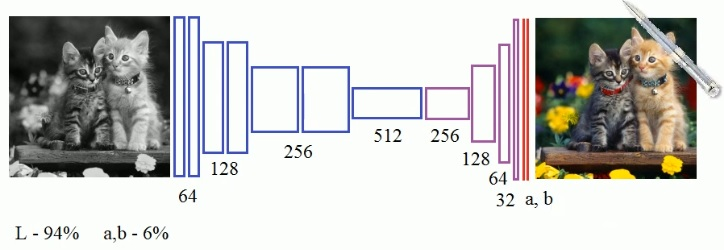

Раскраска изображений:
Lab: (Light - слой яркости (градации серого); a, b - цветовые слои)

L: [0:100], a,b: [-128; 127]

Глаз человека: L - 94%, a,b - 6%

from skimage.color import rgb2lab, lab2rgb
* rgb2lab - преобразовывает изображение из RGB в LAB
* lab2rgb - преобразовывает изображение из LAB в RGB

In [1]:
from keras.layers import Conv2D, UpSampling2D, InputLayer
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
import numpy as np
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
upl = files.upload()
names = list(upl.keys())
img = Image.open(BytesIO(upl[names[0]]))

Saving cats400_2.jpg to cats400_2.jpg
Saving cats400.jpg to cats400.jpg


In [3]:
def processed_image(img):
  image = img.resize( (256, 256), Image.BILINEAR)
  image = np.array(image, dtype=float)
  size = image.shape
  lab = rgb2lab(1.0/255*image)
  X, Y = lab[:,:,0], lab[:,:,1:]

  Y /= 128    # нормируем выходные значение в диапазон от -1 до 1
  X = X.reshape(1, size[0], size[1], 1)
  Y = Y.reshape(1, size[0], size[1], 2)
  return X, Y, size # X - яркостная составляющая, Y - компоненты a и b и размеры изображения

In [4]:
X, Y, size = processed_image(img)

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
# первый свёрточный слой - 64 фильтра(канала), размер ядер 3х3, 
# padding='same' на выходе будем получать тот же самый набор карт признаков что и исходное изображение
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
#тоже самое но шаг сканирования равен 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# следующий слой увеличивает карту признаков в 2 раза покаждой из координат
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [6]:
model.compile(optimizer='adam', loss='mse') # mse - минимумквадрата ошибки
model.fit(x=X, y=Y, batch_size=1, epochs=50)

Epoch 1/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1295
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 0.8090
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.5017
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0141
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 10/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 11/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 12/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 13/50
1/1 [==============================] - 0s 1ms/step - loss: 0.

In [14]:
upl = files.upload()

Saving cats400_2.jpg to cats400_2 (1).jpg


In [15]:
names = list(upl.keys())
img = Image.open(BytesIO(upl[names[0]]))
X, Y, size = processed_image(img)

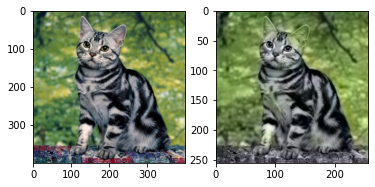

In [16]:
output = model.predict(X)
output *= 128
# Output colorizations
min_vals, max_vals = -128, 127
ab = np.clip(output[0], min_vals, max_vals)

cur = np.zeros((size[0], size[1], 3))
cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100)
cur[:,:,1:] = ab
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(lab2rgb(cur))

В 2016 году Хатоши Иизукаю Эдгар Симо-Серра и Хироши Ишикава
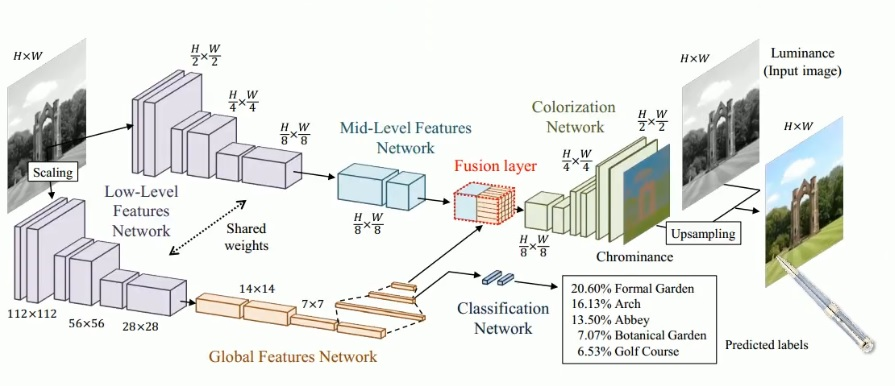